In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from PIL import Image
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import matplotlib.cm as cm
from matplotlib.pyplot import subplots

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib

zsh:1: command not found: nvcc
torch:  2.0 ; cuda:  2.0.1
detectron2: 0.6


In [3]:
ROOT_DIR = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd"

MODEL_DATA_DIR = os.path.join(ROOT_DIR, "processed")

MODEL_TRAIN_DATA_DIR = os.path.join(MODEL_DATA_DIR,"train")
MODEL_VAL_DATA_DIR = os.path.join(MODEL_DATA_DIR,"val")
MODEL_TEST_DATA_DIR = os.path.join(MODEL_DATA_DIR,"test")


# Annotation Dataset

In [4]:
def tuple_to_unique_number(charge_state):
    prime_numbers = [2, 3]  # List of prime numbers, should be equal to number of charge states
    unique_number = sum(element * prime_numbers[index] for index, element in enumerate(charge_state))
    return int(unique_number)

max_charge = 10
all_charge_states = [(i,j) for i in range(max_charge + 1) for j in range(max_charge+1) ]
all_charge_states_values = [tuple_to_unique_number(charge_state) for charge_state in all_charge_states]

charge_state_dict = dict(zip(all_charge_states, all_charge_states_values))
charge_value_dict = dict(zip(all_charge_states_values, all_charge_states))

for test in all_charge_states:
    unique_number = tuple_to_unique_number(test)
    print("{} => {}".format(test, unique_number))

    

(0, 0) => 0
(0, 1) => 3
(0, 2) => 6
(0, 3) => 9
(0, 4) => 12
(0, 5) => 15
(0, 6) => 18
(0, 7) => 21
(0, 8) => 24
(0, 9) => 27
(0, 10) => 30
(1, 0) => 2
(1, 1) => 5
(1, 2) => 8
(1, 3) => 11
(1, 4) => 14
(1, 5) => 17
(1, 6) => 20
(1, 7) => 23
(1, 8) => 26
(1, 9) => 29
(1, 10) => 32
(2, 0) => 4
(2, 1) => 7
(2, 2) => 10
(2, 3) => 13
(2, 4) => 16
(2, 5) => 19
(2, 6) => 22
(2, 7) => 25
(2, 8) => 28
(2, 9) => 31
(2, 10) => 34
(3, 0) => 6
(3, 1) => 9
(3, 2) => 12
(3, 3) => 15
(3, 4) => 18
(3, 5) => 21
(3, 6) => 24
(3, 7) => 27
(3, 8) => 30
(3, 9) => 33
(3, 10) => 36
(4, 0) => 8
(4, 1) => 11
(4, 2) => 14
(4, 3) => 17
(4, 4) => 20
(4, 5) => 23
(4, 6) => 26
(4, 7) => 29
(4, 8) => 32
(4, 9) => 35
(4, 10) => 38
(5, 0) => 10
(5, 1) => 13
(5, 2) => 16
(5, 3) => 19
(5, 4) => 22
(5, 5) => 25
(5, 6) => 28
(5, 7) => 31
(5, 8) => 34
(5, 9) => 37
(5, 10) => 40
(6, 0) => 12
(6, 1) => 15
(6, 2) => 18
(6, 3) => 21
(6, 4) => 24
(6, 5) => 27
(6, 6) => 30
(6, 7) => 33
(6, 8) => 36
(6, 9) => 39
(6, 10) => 42
(7, 

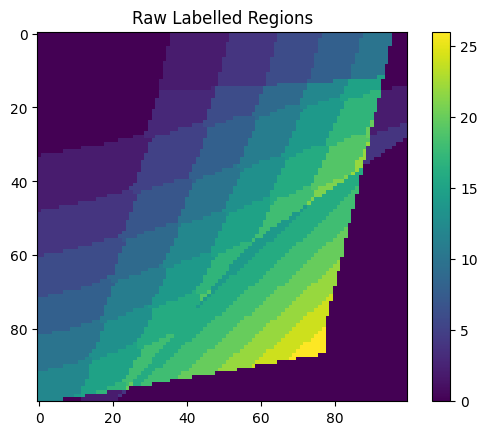

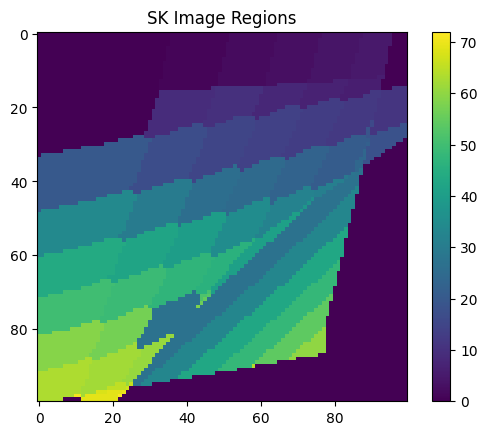

/var/folders/y8/698phn_j78qg7mclyy6h62r00000gn/T/ipykernel_9175/2227117869.py:107: RuntimeWarning: invalid value encountered in scalar divide
  centroid_x /= (6 * signed_area)
/var/folders/y8/698phn_j78qg7mclyy6h62r00000gn/T/ipykernel_9175/2227117869.py:108: RuntimeWarning: invalid value encountered in scalar divide
  centroid_y /= (6 * signed_area)


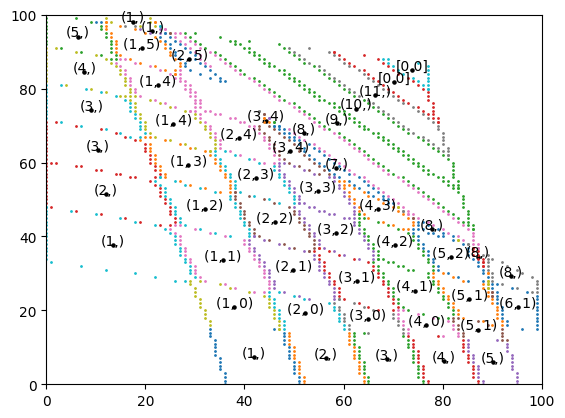

In [30]:
import skimage as sk
# raw
# file_path = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/raw/20200714-140115023515_cr1279.npy"
file_path = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/raw/20171118-123902403990.npy"
file_path = "/Users/andrijapaurevic/Documents/uwaterloo/research/QuantumDotControl/autotuning/data/csd/raw/20171118-130123656336.npy"
# file_path = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/raw/20200711-161944699948_cr145.npy"
# file_path = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/raw/20200714-172019089587_cr1444.npy"

# Loads, *.npy file, extracts CSD
qflow_data = np.load(file_path, allow_pickle=True).item()

voltage_P1_key = "x" if "d_" in file_path else "V_P1_vec"
voltage_P2_key = "y" if "d_" in file_path else "V_P2_vec"
N = len(qflow_data[voltage_P1_key])
M = len(qflow_data[voltage_P2_key])

# try:
csd_qd_states = np.array([
    tuple_to_unique_number(data['charge'])  for data in qflow_data['output']
]).reshape((N,M) if N > M else (M,N))
actual_charge_state_image = np.array([data['charge'] for data in qflow_data['output']], dtype=object).reshape((N,M) if N > M else (M,N))
background = -1
    # correction = 1

# except:
#     print("Can only use 2017 ones")

csd_qd_labelled_regions = sk.measure.label(csd_qd_states, connectivity=1)

csd_qd_regions = sk.measure.regionprops(csd_qd_labelled_regions)

num_of_predicted_regions = len(csd_qd_regions)

plt.imshow(csd_qd_states)
plt.title("Raw Labelled Regions")
plt.colorbar()
plt.show()

plt.imshow(csd_qd_labelled_regions)
plt.title("SK Image Regions")
plt.colorbar()
plt.show()

csd_object_list = []
regions_list = []

fig, ax = plt.subplots()
patches = []

centroid_list = []

for index in range(len(csd_qd_regions)):
    region_info = {}

    region_coords = csd_qd_regions[index].coords

    # Get boundaries of coordiantes
    temp = {}
    for row in region_coords:
        key = row[0]
        value = row[1]
        if key not in temp:
            temp[key] = [value, value]  # Initialize with the current value
        else:
            temp[key][0] = min(temp[key][0], value)  # Update minimum value
            temp[key][1] = max(temp[key][1], value)  # Update maximum value
    region_coords = np.array([[key, minmax[0]] for key, minmax in temp.items()] + [[key, minmax[1]] for key, minmax in temp.items()])

    y,x = region_coords.T

    px = x.tolist()
    py = y.tolist()

    def flip_coordinates_horizontal_axis(x_coordinates, y_coordinates, axis):
        flipped_x_coordinates = []
        flipped_y_coordinates = []
        
        for x, y in zip(x_coordinates, y_coordinates):
            distance = (axis - y)
            y_flipped = axis + distance
            flipped_x_coordinates.append(x)
            flipped_y_coordinates.append(y_flipped)
        
        return flipped_x_coordinates, flipped_y_coordinates

    def find_polygon_centroid(coordinates):

        n = len(coordinates)
        
        # Calculate the signed area of the polygon
        signed_area = 0
        for i in range(n):
            x_i, y_i = coordinates[i]
            x_j, y_j = coordinates[(i + 1) % n]
            signed_area += (x_i * y_j - x_j * y_i)
        signed_area *= 0.5
        
        # Calculate the coordinates of the centroid
        centroid_x = 0
        centroid_y = 0
        for i in range(n):
            x_i, y_i = coordinates[i]
            x_j, y_j = coordinates[(i + 1) % n]
            factor = x_i * y_j - x_j * y_i
            centroid_x += (x_i + x_j) * factor
            centroid_y += (y_i + y_j) * factor
        centroid_x /= (6 * signed_area)
        centroid_y /= (6 * signed_area)
        
        return centroid_x, centroid_y

    def organize_array_clockwise(arr):
            
        # Calculate the centroid of the points
        centroid = np.mean(arr, axis=0)

        # Calculate the angle of each point with respect to the centroid
        angles = np.arctan2(arr[:, 1] - centroid[1], arr[:, 0] - centroid[0])

        # Sort the points based on the angles in clockwise order
        indices = np.argsort(angles)
        sorted_arr = arr[indices]

        return sorted_arr      

    poly = [(x, y) for x, y in zip(px, py)]
    poly = np.array([p for x in poly for p in x]).reshape(-1,2)
    
    poly_clockwise = organize_array_clockwise(poly)
    x0, y0 = find_polygon_centroid(poly_clockwise)
    x0_, y0_ = flip_coordinates_horizontal_axis([x0], [y0], axis=csd_qd_states.shape[0]/2)
    x0_, y0_ = flip_coordinates_horizontal_axis(y0_, x0_, axis=csd_qd_states.shape[1]/2)
    x0_val, y0_val = x0_[0], y0_[0]


    patches.append(matplotlib.patches.Polygon(poly_clockwise))
    if (not(np.isnan(x0)) and not(np.isnan(y0))):
        
        charge_state = actual_charge_state_image[int(x0), int(y0)] 
        # if len(charge_state) == 1:
            # charge_state += (0,)
        # print(int(x0), int(y0), charge_state)
        centroid_list.append([x0, y0]) 
        plt.annotate(f"{charge_state}", (x0,y0), textcoords="offset points", xytext=(0,0), ha='center')
    plt.scatter([x0],[y0],c='black', s=5)

    plt.scatter(px,py, s=1)
    
plt.xlim(0,N)
plt.ylim(0,M)
plt.show()



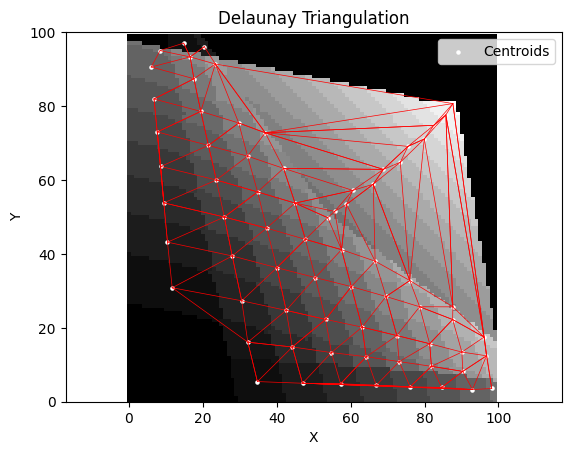

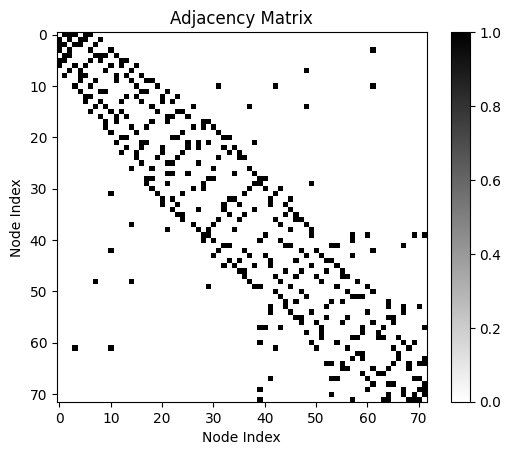

(1, 0) (2, 1)


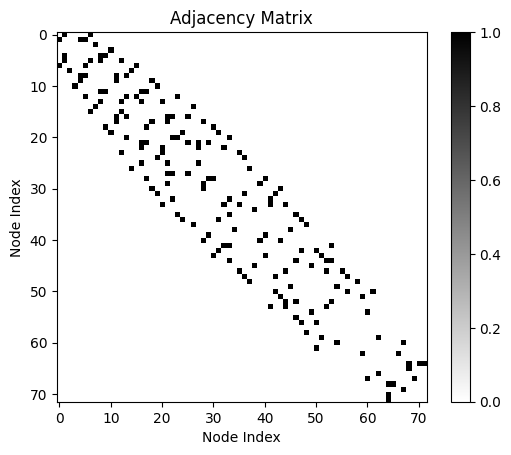

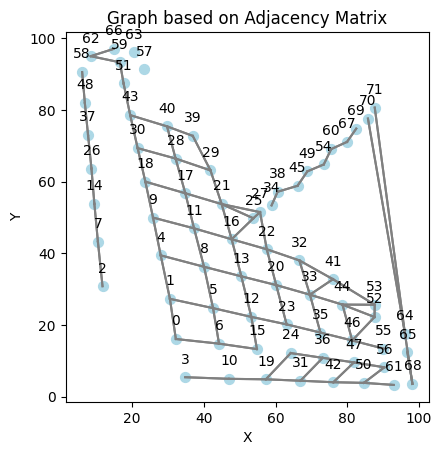

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Assuming you have the 'points' array with the coordinates of the points
points = np.array(centroid_list)


# Target point
target_point = np.array([20,20])

# Custom distance calculation function
def distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Calculate distances from the target point for each coordinate
distances = np.array([distance(coord, target_point) for coord in points])

# Sort the coordinates based on distances
sorted_indices = np.argsort(distances)

# Sorted coordinates
points = points[sorted_indices]

# Perform Delaunay triangulation
tri = Delaunay(points)

# Get the simplices of the triangular mesh
triangles = tri.simplices

# Create adjacency matrix
adjacency_matrix = np.zeros((len(points), len(points)))
for triangle in triangles:
    adjacency_matrix[triangle[0], triangle[1]] = 1
    adjacency_matrix[triangle[1], triangle[0]] = 1
    adjacency_matrix[triangle[0], triangle[2]] = 1
    adjacency_matrix[triangle[2], triangle[0]] = 1
    adjacency_matrix[triangle[1], triangle[2]] = 1
    adjacency_matrix[triangle[2], triangle[1]] = 1

plt.imshow(csd_qd_states, cmap='gray')

# Plot the points
plt.scatter(points[:, 0], points[:, 1], c='white', label='Centroids', s=5)

# Plot the Delaunay triangles with color based on distance
for i, triangle in enumerate(triangles):

    x = points[triangle, 0]
    y = points[triangle, 1]
    plt.plot(points[triangle, 0], points[triangle, 1], 'r-', linewidth=0.5)

# Set axis labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Delaunay Triangulation')

# Set aspect ratio to equal and show the plot
plt.axis('equal')
plt.xlim([0, N])
plt.ylim([0, M])
plt.legend()
plt.show()

# Plot the adjacency matrix
plt.imshow(adjacency_matrix, cmap='binary')
plt.title('Adjacency Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.colorbar()
plt.show()


# Get the number of nodes
num_nodes = adjacency_matrix.shape[0]

filtered_adj_matrix = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(num_nodes):
        if adjacency_matrix[i,j] == 1:
            
            coord1 = points[i]
            x0, y0 = coord1
            charge_state_1 = actual_charge_state_image[int(x0), int(y0)] 

            coord2 = points[j]
            x0, y0 = coord2
            charge_state_2 = actual_charge_state_image[int(x0), int(y0)] 

            if len(charge_state_1) == 1 and len(charge_state_2) == 1:
                charge_state_diff = [charge_state_1[0] - charge_state_2[0]]
                if -1 in charge_state_diff or 1 in charge_state_diff:
                    filtered_adj_matrix[i,j] = 1

            elif len(charge_state_1) == 2 and len(charge_state_2) == 2: 

                total_charge_1 = charge_state_1[0] + charge_state_1[1]

            
                # if len(charge_state_2) == 1:
                #     charge_state_2 += (0,)

                total_charge_2 = charge_state_2[0] + charge_state_2[1]
                
                charge_state_diff = tuple((charge_state_1[0] - charge_state_2[0], charge_state_1[1] - charge_state_2[1]))

                if i == 0 and j == 5:
                    print(charge_state_1, charge_state_2)
                if 0 in charge_state_diff and (1 in charge_state_diff or -1 in charge_state_diff):
                    filtered_adj_matrix[i,j] = 1
                if (1 in charge_state_diff and -1 in charge_state_diff) and total_charge_1 == total_charge_2:
                    filtered_adj_matrix[i,j] = 1
            # if charge
            #     if charge_state_1 + (0,) == charge_state_2:
            #         filtered_adj_matrix[i,j] = 1

adjacency_matrix = filtered_adj_matrix
# adjacency_matrix[:,:] =0 
# for i in range(num_nodes):
#     adjacency_matrix[i, (i+1) % num_nodes] = 1

# adjacency_matrix[:,:] =0 
# adjacency_matrix[0,2] =1 
# adjacency_matrix[1,2] =1 
# adjacency_matrix[1,7] =1 
# adjacency_matrix[7,18] =1 
# adjacency_matrix[18,15] =1 
# adjacency_matrix[15,4] =1 
# adjacency_matrix[4,2] =1 
# adjacency_matrix[2,0] =1 
# adjacency_matrix[0,3] =1 
# adjacency_matrix[7,4] =1 
# adjacency_matrix[4,8] =1 
# adjacency_matrix[15,12] =1 
# adjacency_matrix[12,8] =1 
# adjacency_matrix[8,5] =1 
# adjacency_matrix[2,5] =1 
# adjacency_matrix[0,6] =1 
# adjacency_matrix[3,9] =1 
# adjacency_matrix[5,6] =1 
# adjacency_matrix[6,9] =1 
# adjacency_matrix[6,16] =1 
# adjacency_matrix[16,19] =1 
# adjacency_matrix[9,19] =1 
# adjacency_matrix[5,14] =1
# adjacency_matrix[14,16] =1  
# adjacency_matrix[14,20] =1 
# adjacency_matrix[13,14] =1 
# adjacency_matrix[8,11] =1 
# adjacency_matrix[8,10] =1 
# adjacency_matrix[10,17] =1 
# adjacency_matrix[17,21] =1 
# adjacency_matrix[21,22] =1 
# adjacency_matrix[22,23] =1 
# Plot the adjacency matrix
plt.imshow(adjacency_matrix, cmap='binary')
plt.title('Adjacency Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.colorbar()
plt.show()

# 12, 17, 20, 23

# Plot the graph
fig, ax = plt.subplots()
# ax.imshow(csd_qd_states, cmap='gray')

ax.set_aspect('equal')

# Draw nodes
ax.scatter(points[:, 0], points[:, 1], c='lightblue', s=50)
# Add text annotations for each point
for i, point in enumerate(points):
    ax.annotate(str(i), (point[0], point[1]), textcoords="offset points",
                xytext=(0, 10), ha='center')
# Draw edges
for i in range(num_nodes):
    for j in range(num_nodes):
        if adjacency_matrix[i, j] == 1:

            ax.plot([points[i, 0], points[j, 0]],
                    [points[i, 1], points[j, 1]], color='gray')
            label = f"{i}, {j}"
            mid_x = (points[i, 0] + points[j, 0]) / 2
            mid_y = (points[i, 1] + points[j, 1]) / 2
            # ax.text(mid_x, mid_y, label, ha='center', va='center')

# Set axis labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graph based on Adjacency Matrix')

# Show the plot
plt.show()

# Detectron2 Dataset

In [274]:
from detectron2.structures import BoxMode

def get_csd_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = v["height"], v["width"]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            regions = anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]

            
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            category_dict = {"ND": 0, "LD": 1, "CD": 2, "RD": 3, "DD": 4}
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_dict[regions["label"]],
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20200714-145234540560_cr1375.jpg
/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20171118-131209334790.jpg
/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20171118-133654695037.jpg
/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20171118-131436298418.jpg
/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20200714-130902356984_cr1086.jpg
/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20200712-155326004026_cr617.jpg
/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/train/20171118-130039380140.jpg


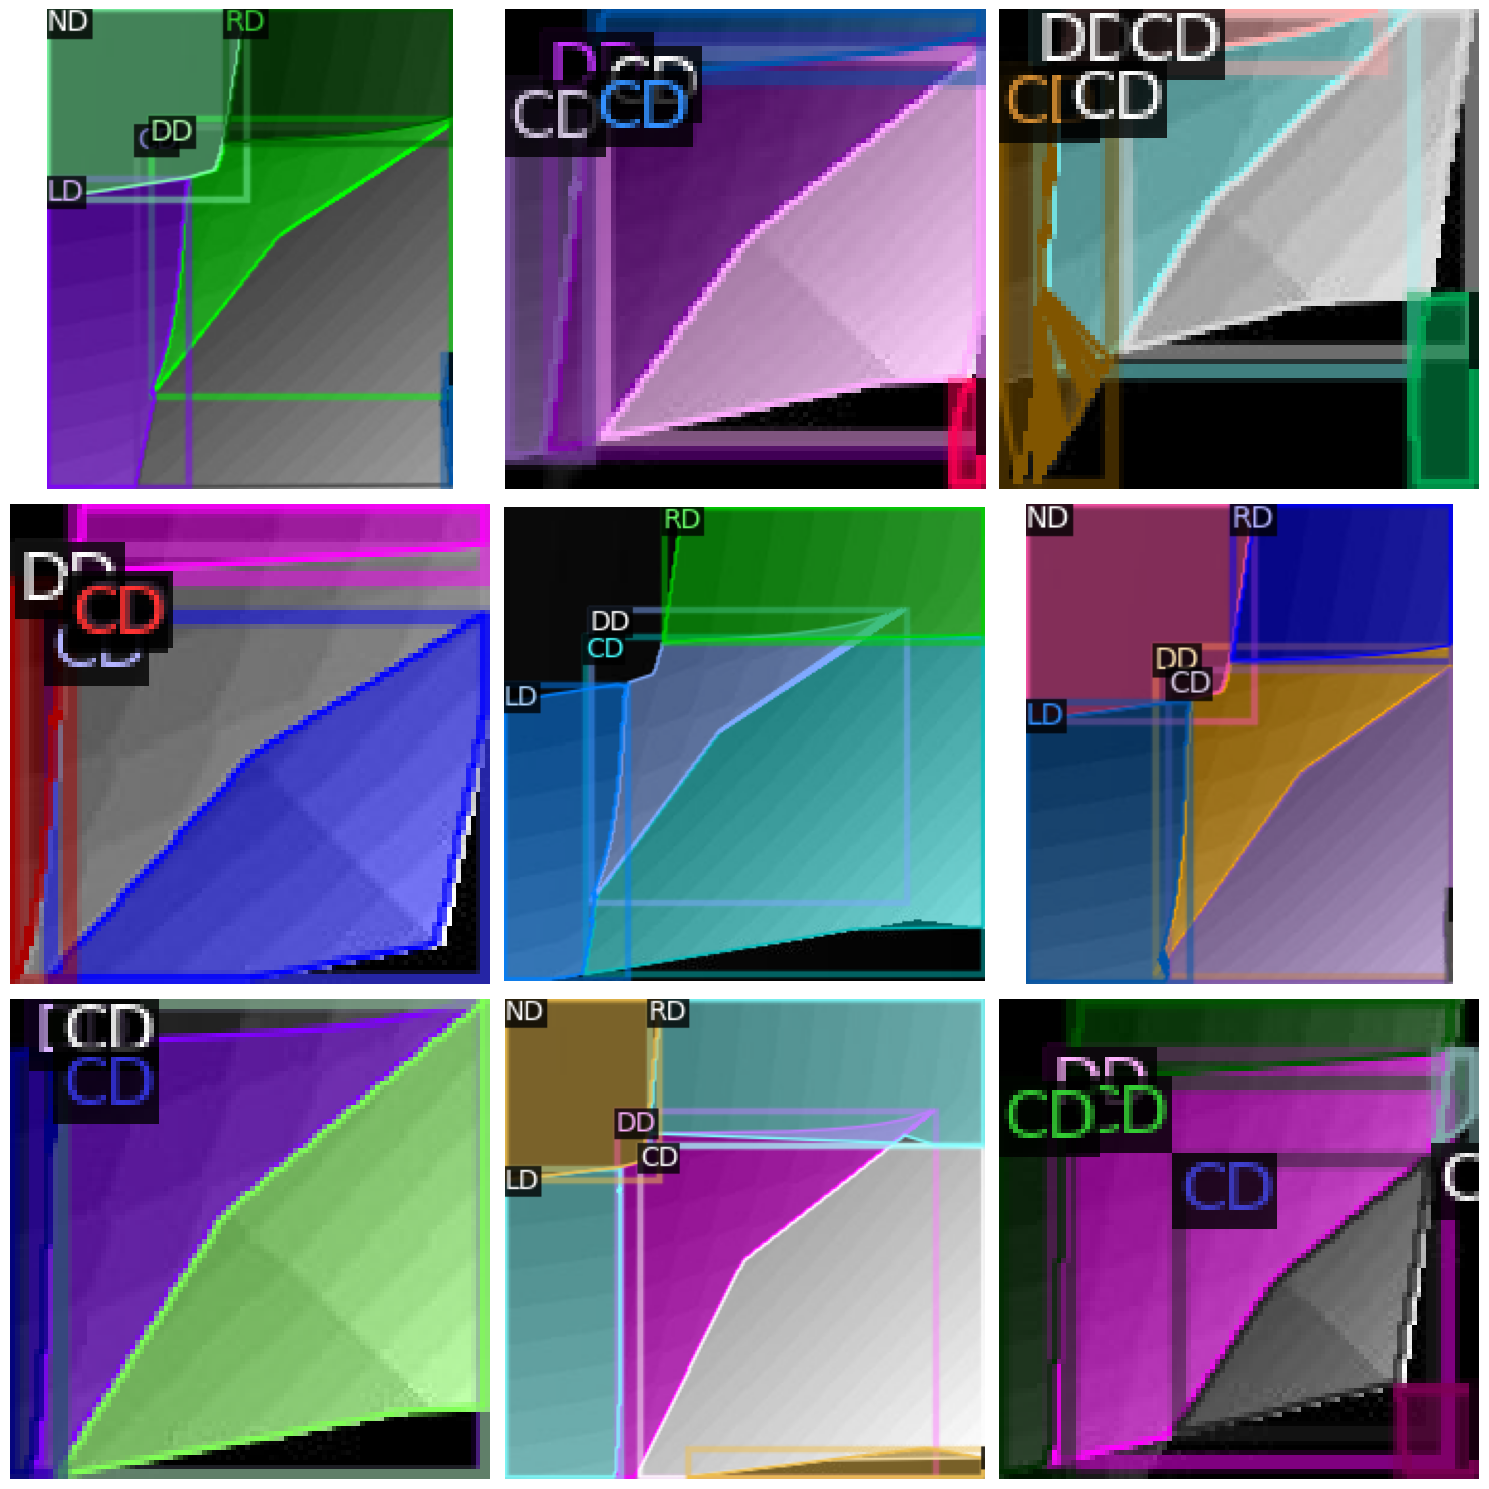

In [288]:
DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["train", "val", "test"]:
    DatasetCatalog.register("csd_" + d, lambda d=d: get_csd_dicts(os.path.join(MODEL_DATA_DIR,d)))
    MetadataCatalog.get("csd_" + d).set(thing_classes=["ND", "LD", "CD", "RD", "DD"])
    MetadataCatalog.get("csd_" + d).set(thing_colors=[(255,0,0),(0,255,0),(0,0,255)])

csd_metadata = MetadataCatalog.get("csd_train")
csd_test_metadata = MetadataCatalog.get("csd_test")

dataset_dicts = get_csd_dicts(MODEL_TRAIN_DATA_DIR)

num_of_display_images = 9

num_cols = min(3, num_of_display_images)  # Maximum of 3 columns
num_rows = int(np.ceil(num_of_display_images / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, d in enumerate(random.sample(dataset_dicts, num_of_display_images)):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=csd_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    if num_rows > 1:
        ax = axs[i // num_cols, i % num_cols]
    else:
        ax = axs[i % num_cols]
    ax.imshow(out.get_image()[:, :, ::-1])
    ax.axis("off")

plt.tight_layout()
plt.show()

In [295]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("csd_train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.DEVICE = "cpu"

cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 5  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300 # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join("/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/output", "model_charge_sensor_5000.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set a custom testing threshold
predictor = DefaultPredictor(cfg)


[06/21 17:44:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/output/model_charge_sensor_5000.pth ...


# Validation Dataset

All masks are false?:  False


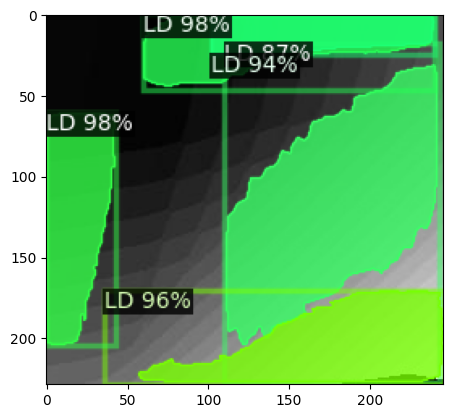

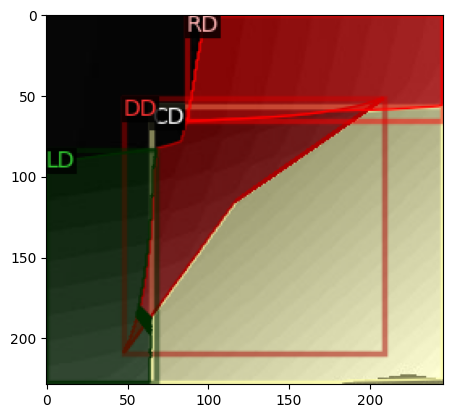

In [296]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_csd_dicts(MODEL_VAL_DATA_DIR)
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    v = Visualizer(im[:, :, ::-1],
                   metadata=csd_metadata, 
                   scale=1,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
                   instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels
    )

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()
    
    plt.cla()
    plt.clf()
    plt.close()
    visualizer = Visualizer(im[:, :, ::-1], metadata=csd_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1],cmap=cm.summer)
    plt.show()

# Experimental Dataset

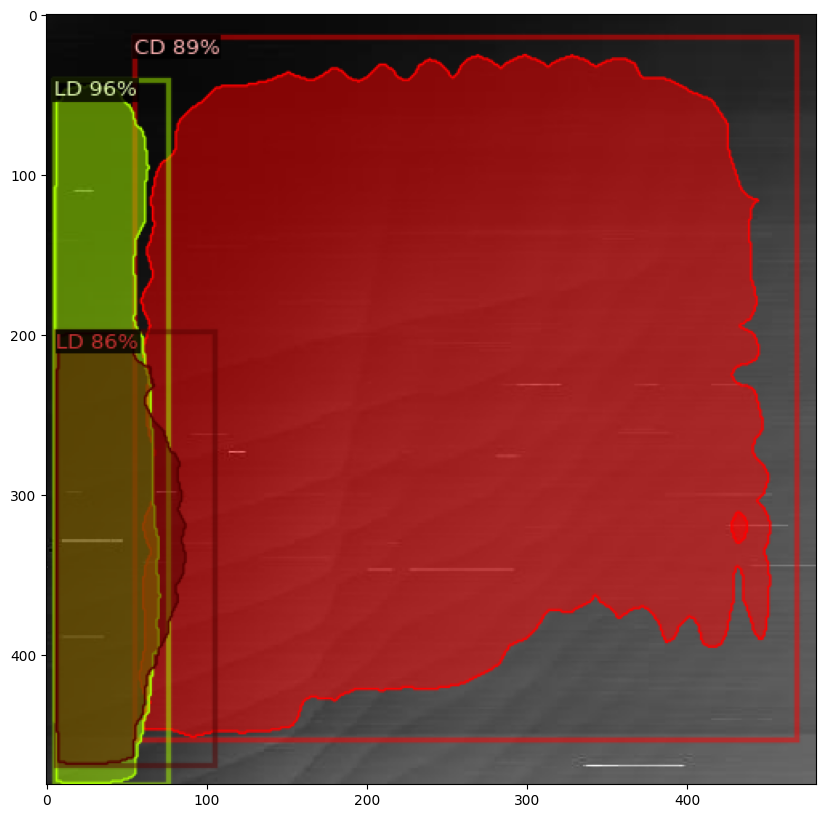

In [297]:
im = cv2.imread("/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/test/exp_large_02.jpg")
im = cv2.rotate(im, cv2.ROTATE_180)
outputs = predictor(im)

v = Visualizer(im[:, :, ::-1], csd_test_metadata, scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))